In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  1 08:58:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
%load_ext tensorboard
!rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
import os, sys, glob, re, time, datetime
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard


In [48]:
def numerical_sort(value):
    """
    Splits out any digits in a filename, turns it into an actual number, and returns the result for sorting.
    :param value: filename
    :return:

    author: kei
    date: 20190903
    """
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


def explore_ds(path, file_type):
  print(path) #print path
  os.chdir(path)
  ds = sorted(glob.glob(file_type), key=numerical_sort)
  # print(ds) #print contents
  return ds


def visualize_ds(images, vis=False):
  
  samples = len(images)
  # print('total images', samples)

  if vis:
    fig = plt.figure(figsize=(10,samples))
    fig.subplots_adjust(hspace=0.1)
  
  for p in range(samples):
    img = plt.imread(images[p])
    img = cv2.resize(img, (width, height))

    BATCH.append(img) #global variable

    if vis:
      ax = fig.add_subplot(samples//2, 4, p+1)
      ax.axis('off')
      ax.imshow(img)
    

def process_ds(dir_list):
  for group in dir_list:
    images = explore_ds(os.path.join(path, dir, group), '*.jpg')
    visualize_ds(images, vis=False)
    # break



# clone sample images
path = '/content/drive/MyDrive/ds/pushing'
sys.path.append(path)
dirs = os.listdir(path)

width = 300
height =300 

BATCH = []

start = time.time()
for dir in dirs:
  dir_list = explore_ds(os.path.join(path, dir), 'group*')
  process_ds(dir_list)

  # if dir=='05':
  break
  

end = time.time()
print('total time spent {}'.format((end-start)/60))

print(len(BATCH))


/content/drive/MyDrive/ds/pushing/04
/content/drive/MyDrive/ds/pushing/04/group113
/content/drive/MyDrive/ds/pushing/04/group119
/content/drive/MyDrive/ds/pushing/04/group120
/content/drive/MyDrive/ds/pushing/04/group124
/content/drive/MyDrive/ds/pushing/04/group125
/content/drive/MyDrive/ds/pushing/04/group126
/content/drive/MyDrive/ds/pushing/04/group127
/content/drive/MyDrive/ds/pushing/04/group128
/content/drive/MyDrive/ds/pushing/04/group131
total time spent 0.04602406024932861
545


In [58]:
start = time.time()

ds = tf.stack(BATCH) #create tensor of samples

end = time.time()
print('total time spent {}'.format((end-start)/60))


total time spent 1.028384800752004


In [59]:
# split dataset train and test

ratio = int(len(ds)*.7)

train_ds = ds[1:ratio,:]
test_ds = ds[ratio:,:]

print(train_ds.shape, test_ds.shape)


(380, 300, 300, 3) (164, 300, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(380, 300, 300, 3)


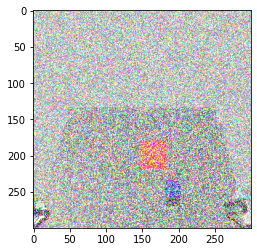

In [60]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
  
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)


gaussian_train_ds = add_gaussian_to_dataset(train_ds)
gaussian_test_ds = add_gaussian_to_dataset(test_ds)

plt.imshow(gaussian_train_ds[1,:])
print(gaussian_train_ds.shape)

In [61]:
train_ds = train_ds / 255
test_ds = test_ds / 255

# # reduce images
gaussian_train_ds = gaussian_train_ds / 255.0 
gaussian_test_ds = gaussian_test_ds / 255.0

In [79]:
# https://www.tensorflow.org/tutorials/generative/autoencoder
# put the Activation layer AFTER the BatchNormalization() layer
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()


## ENCODER ##
encoder_input = keras.Input(shape=(width, height, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
encoder_output = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()


# initialize the model
size_=38
channels_=16

## DECODER ##
decoder_input = keras.Input(shape=(size_, size_, channels_), name='encoded_img')
reshape = layers.Reshape((size_, size_, channels_))(decoder_input)

d_conv1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(reshape)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = layers.Conv2D(64, (3, 3), activation='relu')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)

decoder_output = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()


autoencoder_input = keras.Input(shape=(width,height,3), name='img')
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = keras.Model(autoencoder_input, decoded_img, name='autoencoder')

opt = tf.keras.optimizers.Adam(learning_rate=1e-3) #Adamax
autoencoder.compile(loss='mse', metrics=["mae", "acc"], optimizer=opt)

autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

In [ ]:
# keras.utils.plot_model(gaussian_auto_encoder.encoder, "e.png", show_shapes=True)

In [ ]:
# keras.utils.plot_model(gaussian_auto_encoder.decoder, "d.png", show_shapes=True)

In [81]:
start = time.time()


# create checkpoint and save best weight
checkpoint_path = "/content/ae_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='min',
                                                 save_best_only=True)

# early stopping if not changing for 50 epochs
early_stop = EarlyStopping(monitor='loss', #'val_loss',
                          patience=60,
                          verbose=1)

# reduce learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                factor=0.1,
                                                patience=25, 
                                                verbose=1,
                                                min_lr=1e-3)


# record on tensorboard
logdir = "logs/ae" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# train the model
ae_history = autoencoder.fit(gaussian_train_ds,
                            train_ds, 
                            epochs=500, 
                            batch_size=64,
                            shuffle=True,
                            # validation_split=0.2,
                            validation_data=(gaussian_test_ds, test_ds),
                            callbacks=[cp_callback, early_stop, reduce_lr, tb_callback])


end = time.time()
print('\ntotal time spent {}'.format((end-start)/60))

Epoch 1/500
6/6 [==============================] - 8s 1s/step - loss: 0.0149 - mae: 0.0837 - acc: 0.4709 - val_loss: 0.0390 - val_mae: 0.1515 - val_acc: 0.0494

Epoch 00001: val_loss improved from inf to 0.03903, saving model to /content/ae_cp/cp.ckpt
Epoch 2/500
6/6 [==============================] - 2s 391ms/step - loss: 0.0057 - mae: 0.0466 - acc: 0.6448 - val_loss: 0.0404 - val_mae: 0.1559 - val_acc: 0.9146

Epoch 00002: val_loss did not improve from 0.03903
Epoch 3/500
6/6 [==============================] - 2s 391ms/step - loss: 0.0045 - mae: 0.0406 - acc: 0.7707 - val_loss: 0.0410 - val_mae: 0.1583 - val_acc: 0.9181

Epoch 00003: val_loss did not improve from 0.03903
Epoch 4/500
6/6 [==============================] - 2s 387ms/step - loss: 0.0038 - mae: 0.0366 - acc: 0.7325 - val_loss: 0.0412 - val_mae: 0.1596 - val_acc: 0.9182

Epoch 00004: val_loss did not improve from 0.03903
Epoch 5/500
6/6 [==============================] - 2s 389ms/step - loss: 0.0034 - mae: 0.0340 - acc: 0.

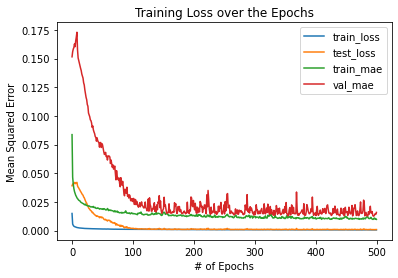

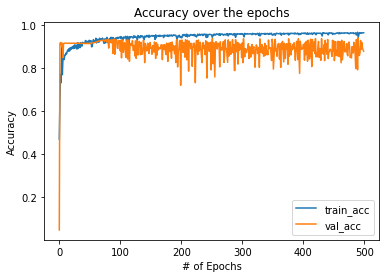

In [82]:
plt.figure(1)
plt.plot(ae_history.epoch, ae_history.history['loss'], label='train_loss')
plt.plot(ae_history.epoch, ae_history.history['val_loss'], label='test_loss')
plt.plot(ae_history.epoch, ae_history.history['mae'], label='train_mae')
plt.plot(ae_history.epoch, ae_history.history['val_mae'], label='val_mae')

plt.title('Training Loss over the Epochs')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(ae_history.epoch, ae_history.history['acc'], label='train_acc')
plt.plot(ae_history.epoch, ae_history.history['val_acc'], label='val_acc')

plt.title('Accuracy over the epochs')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [91]:
# # load_best_checkpoint and evaluate
# cp_model = autoencoder(latent_dim)
# cp_model.compile(loss='mse', optimizer=opt)
autoencoder.load_weights(checkpoint_path)
cp_loss = autoencoder.evaluate(gaussian_test_ds, test_ds)

# # evaluate the model on the test set
# final_loss = autoencoder.evaluate(gaussian_test_ds, test_ds)

6/6 [==============================] - 0s 56ms/step - loss: 7.4622e-04 - mae: 0.0125 - acc: 0.9281


# DENOISED IMAGES

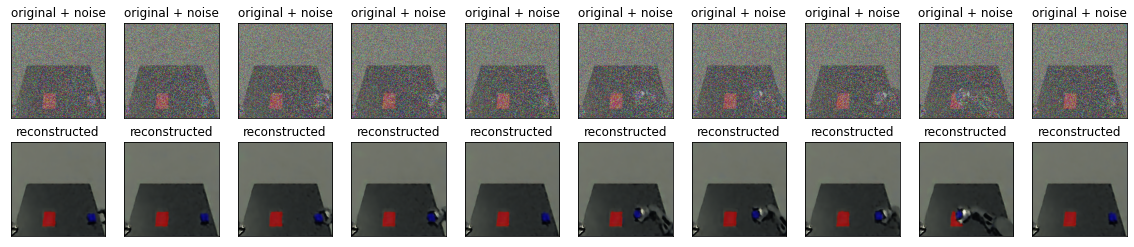

In [92]:
# run model on the test_ds to reconstruct
cp_result = autoencoder.predict(gaussian_test_ds)

n = 10
idx = [np.random.randint(1,100) for i in range(n)]
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow((gaussian_test_ds[idx[i]]*255).astype(np.uint8))
    # plt.imshow(test_ds[idx[i]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow((cp_result[idx[i]]*255).astype(np.uint8))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

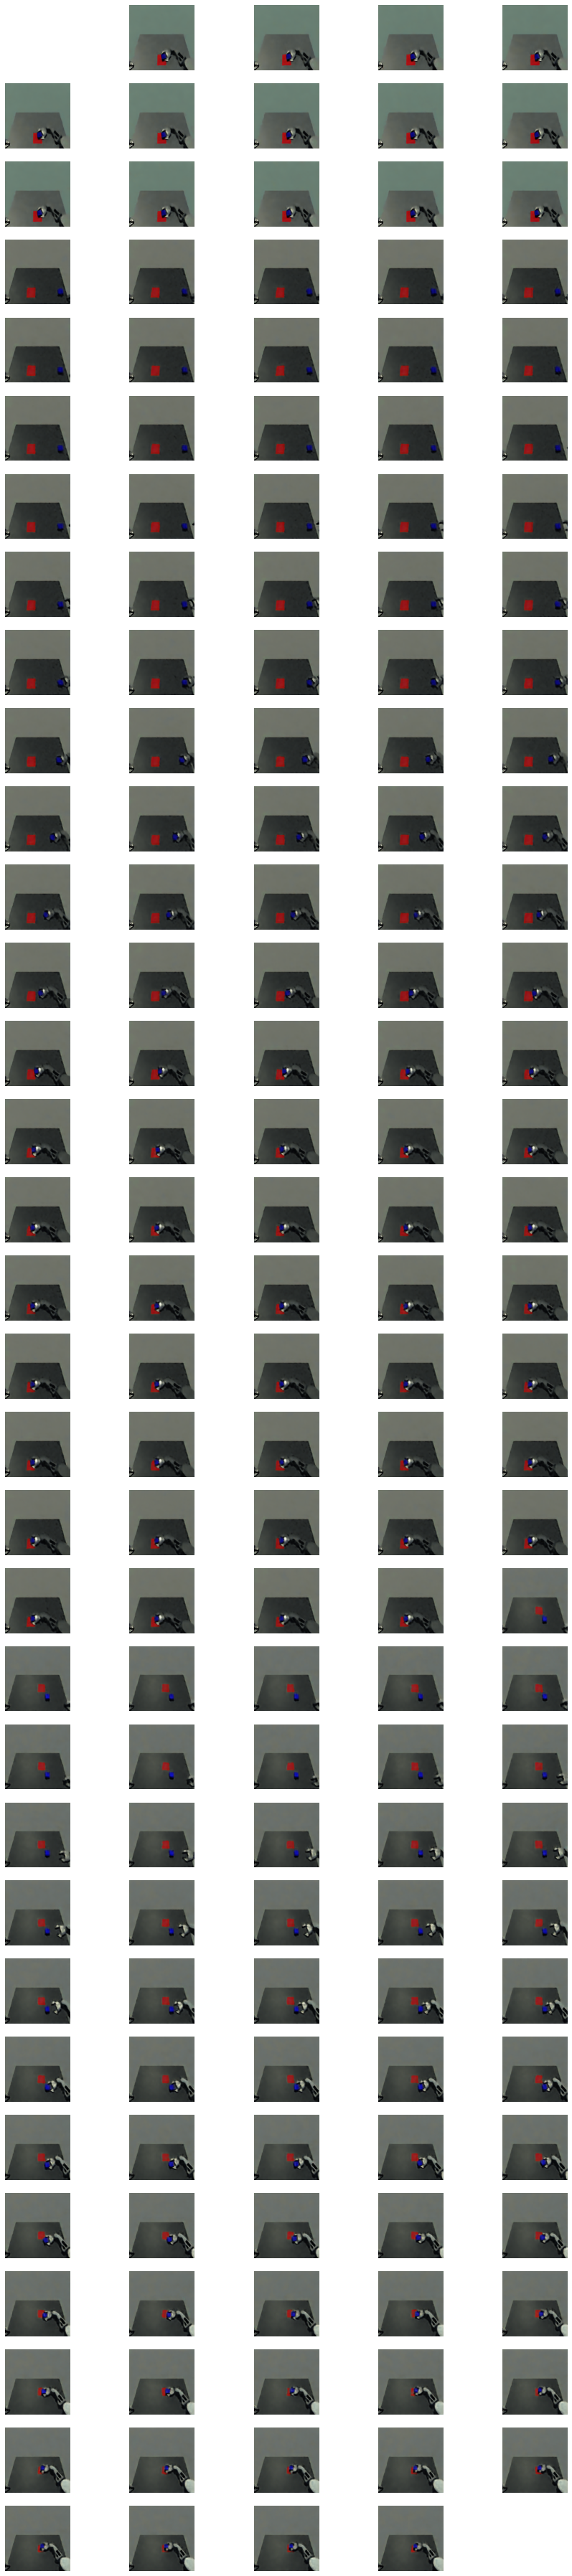

In [87]:
final_result = autoencoder.predict(gaussian_test_ds)

samples = len(final_result)
fig = plt.figure(figsize=(15, samples))
for p in range(1, samples):
  ax = fig.add_subplot(samples//2, 5, p+1)
  ax.imshow((final_result[p]*255).astype(np.uint8))
  ax.axis('off')

# Original Test Images

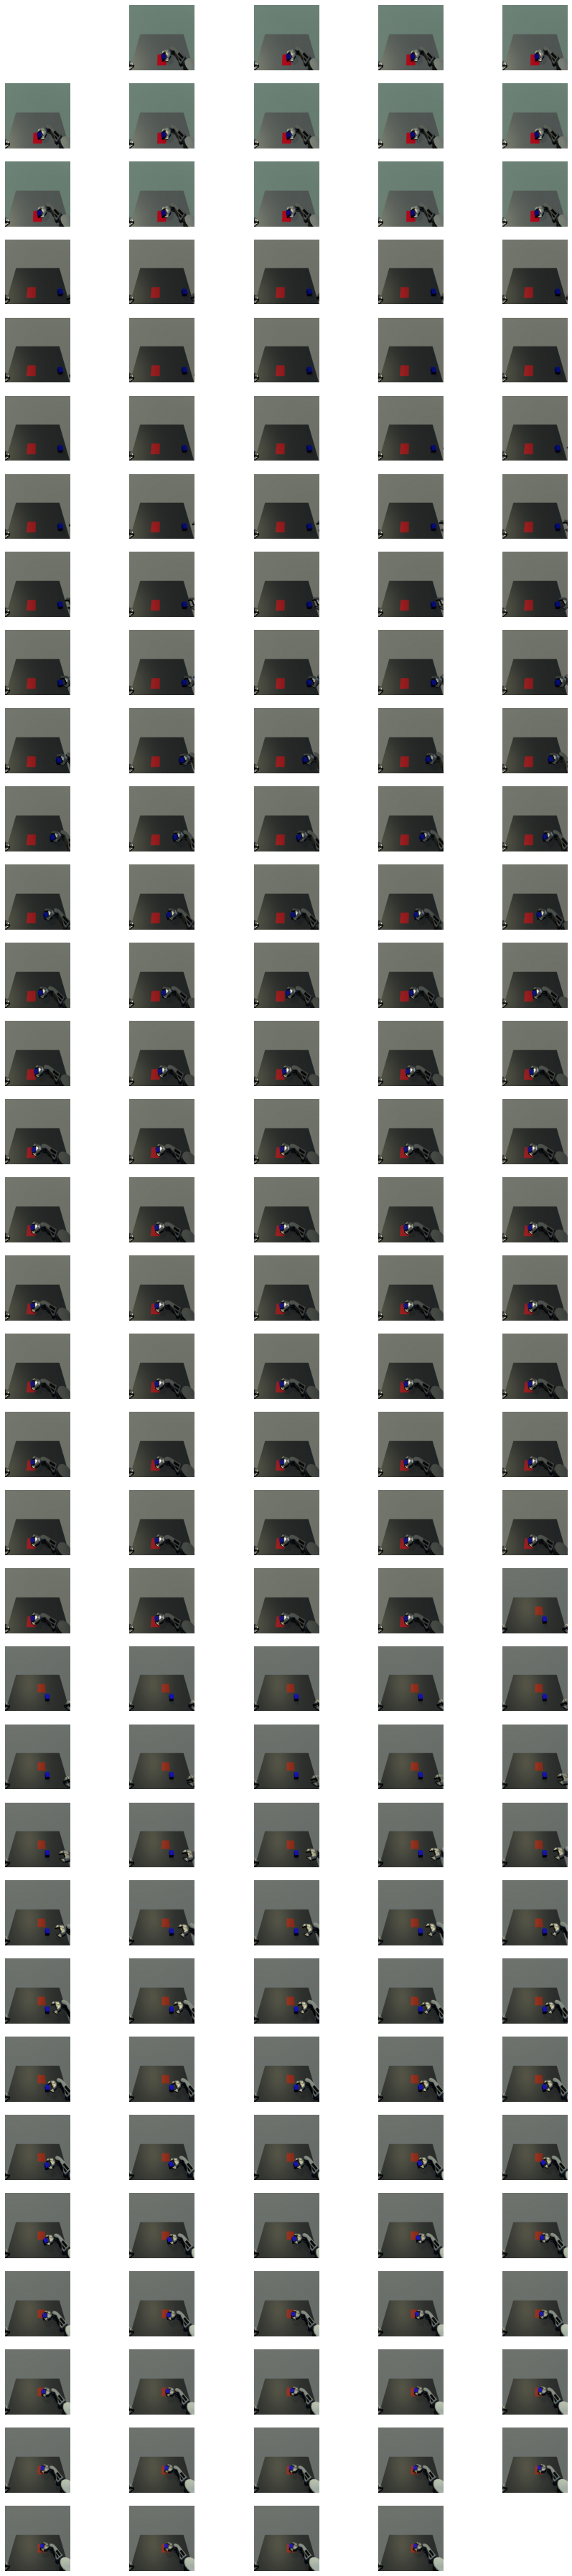

In [88]:
fig = plt.figure(figsize=(15, samples))
for p in range(1, samples):
  ax = fig.add_subplot(samples//2, 5, p+1)
  ax.imshow(test_ds[p])
  ax.axis('off')

In [90]:
# https://www.tensorflow.org/tensorboard/scalars_and_keras
# %tensorboard --logdir logs/ae